<a href="https://colab.research.google.com/github/siddharth3444/detect_window/blob/main/Loading_Image_and_training_model_deploy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!rm -rf ./dataset

In [5]:
!unzip ./dataset_final.zip -d ./dataset

Archive:  ./dataset_final.zip
   creating: ./dataset/annotations/
   creating: ./dataset/images/
  inflating: ./dataset/sceneCategories.txt  
   creating: ./dataset/annotations/testing/
   creating: ./dataset/annotations/training/
  inflating: ./dataset/annotations/testing/14.png  
  inflating: ./dataset/annotations/testing/9.png  
  inflating: ./dataset/annotations/testing/1.png  
  inflating: ./dataset/annotations/training/12.png  
  inflating: ./dataset/annotations/training/11.png  
  inflating: ./dataset/annotations/training/6.png  
  inflating: ./dataset/annotations/training/15.png  
  inflating: ./dataset/annotations/training/4.png  
  inflating: ./dataset/annotations/training/10.png  
  inflating: ./dataset/annotations/training/20.png  
  inflating: ./dataset/annotations/training/19.png  
  inflating: ./dataset/annotations/training/3.png  
  inflating: ./dataset/annotations/training/13.png  
  inflating: ./dataset/annotations/training/7.png  
  inflating: ./dataset/annotations/t

In [6]:
id2label={0:'window',1:'curtain',2:'door'}

In [7]:
import os
import cv2
from PIL import Image


image_data_dir='/content/dataset/images'
annotation_data_dir='/content/dataset/annotations'

train_data=[]
cn=0
for item in os.listdir(f"{image_data_dir}/training"):
  obj={}
  name=item.split(".")[0]
  obj['image']=Image.open(f"{image_data_dir}/training/{name}.jpg")
  obj['annotation']=Image.open(f"{annotation_data_dir}/training/{name}.png")
  train_data.append(obj)
  # if cn>=5:
  #   break
  # cn+=1


cn=0
test_data=[]
for item in os.listdir(f"{image_data_dir}/testing"):
  obj={}
  name=item.split(".")[0]
  obj['image']=Image.open(f"{image_data_dir}/testing/{name}.jpg")
  obj['annotation']=Image.open(f"{annotation_data_dir}/testing/{name}.png")
  test_data.append(obj)
  # if cn>=5:
  #   break
  # cn+=1

train_data
test_data
index=2

In [8]:
print(len(train_data))
print(len(test_data))

19
3


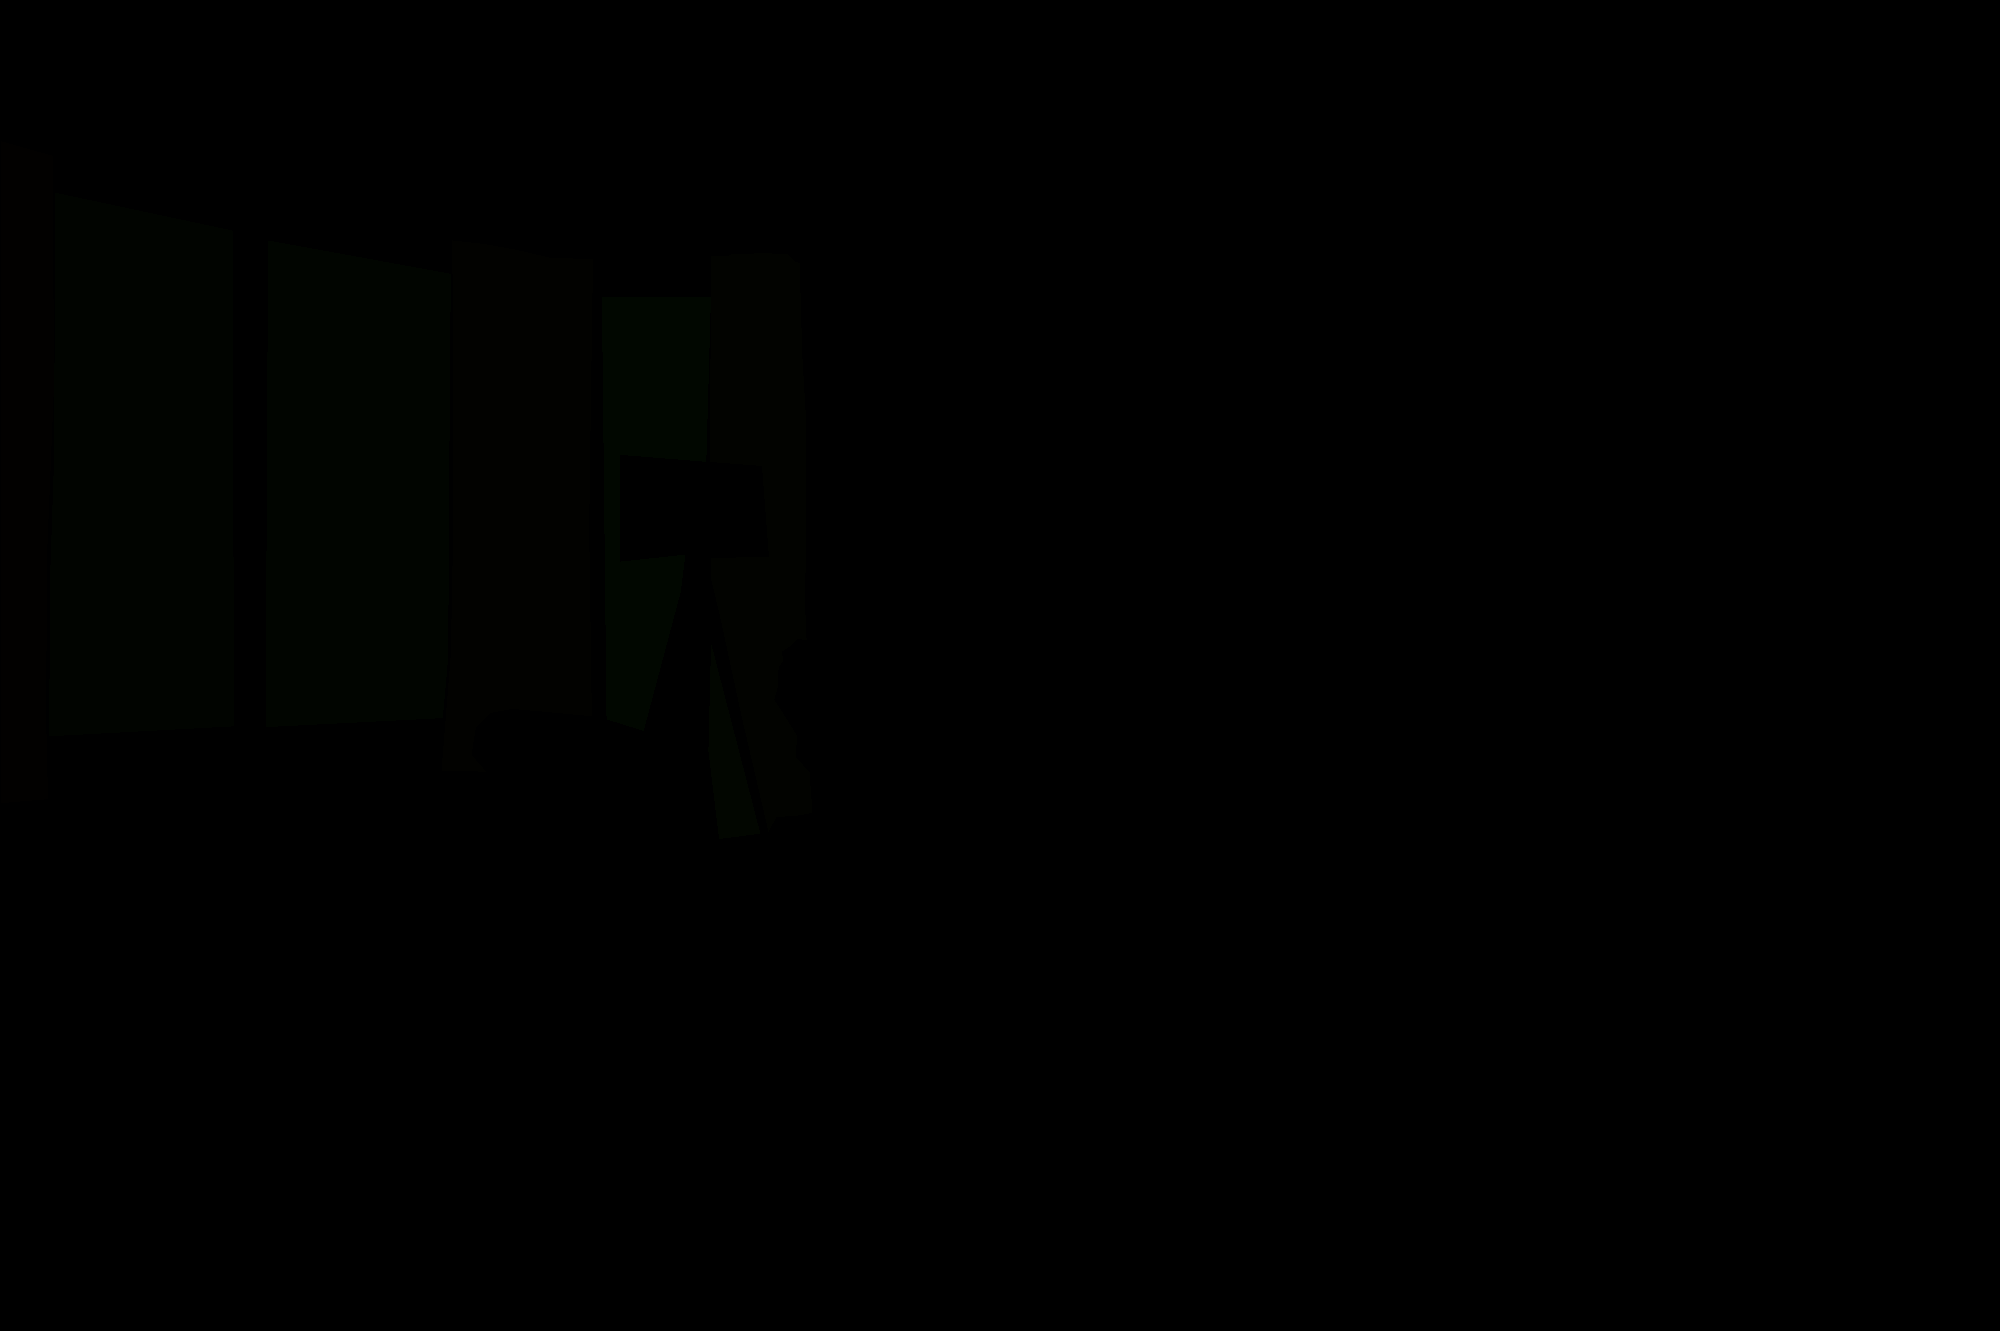

In [10]:
test_data[index]['annotation']

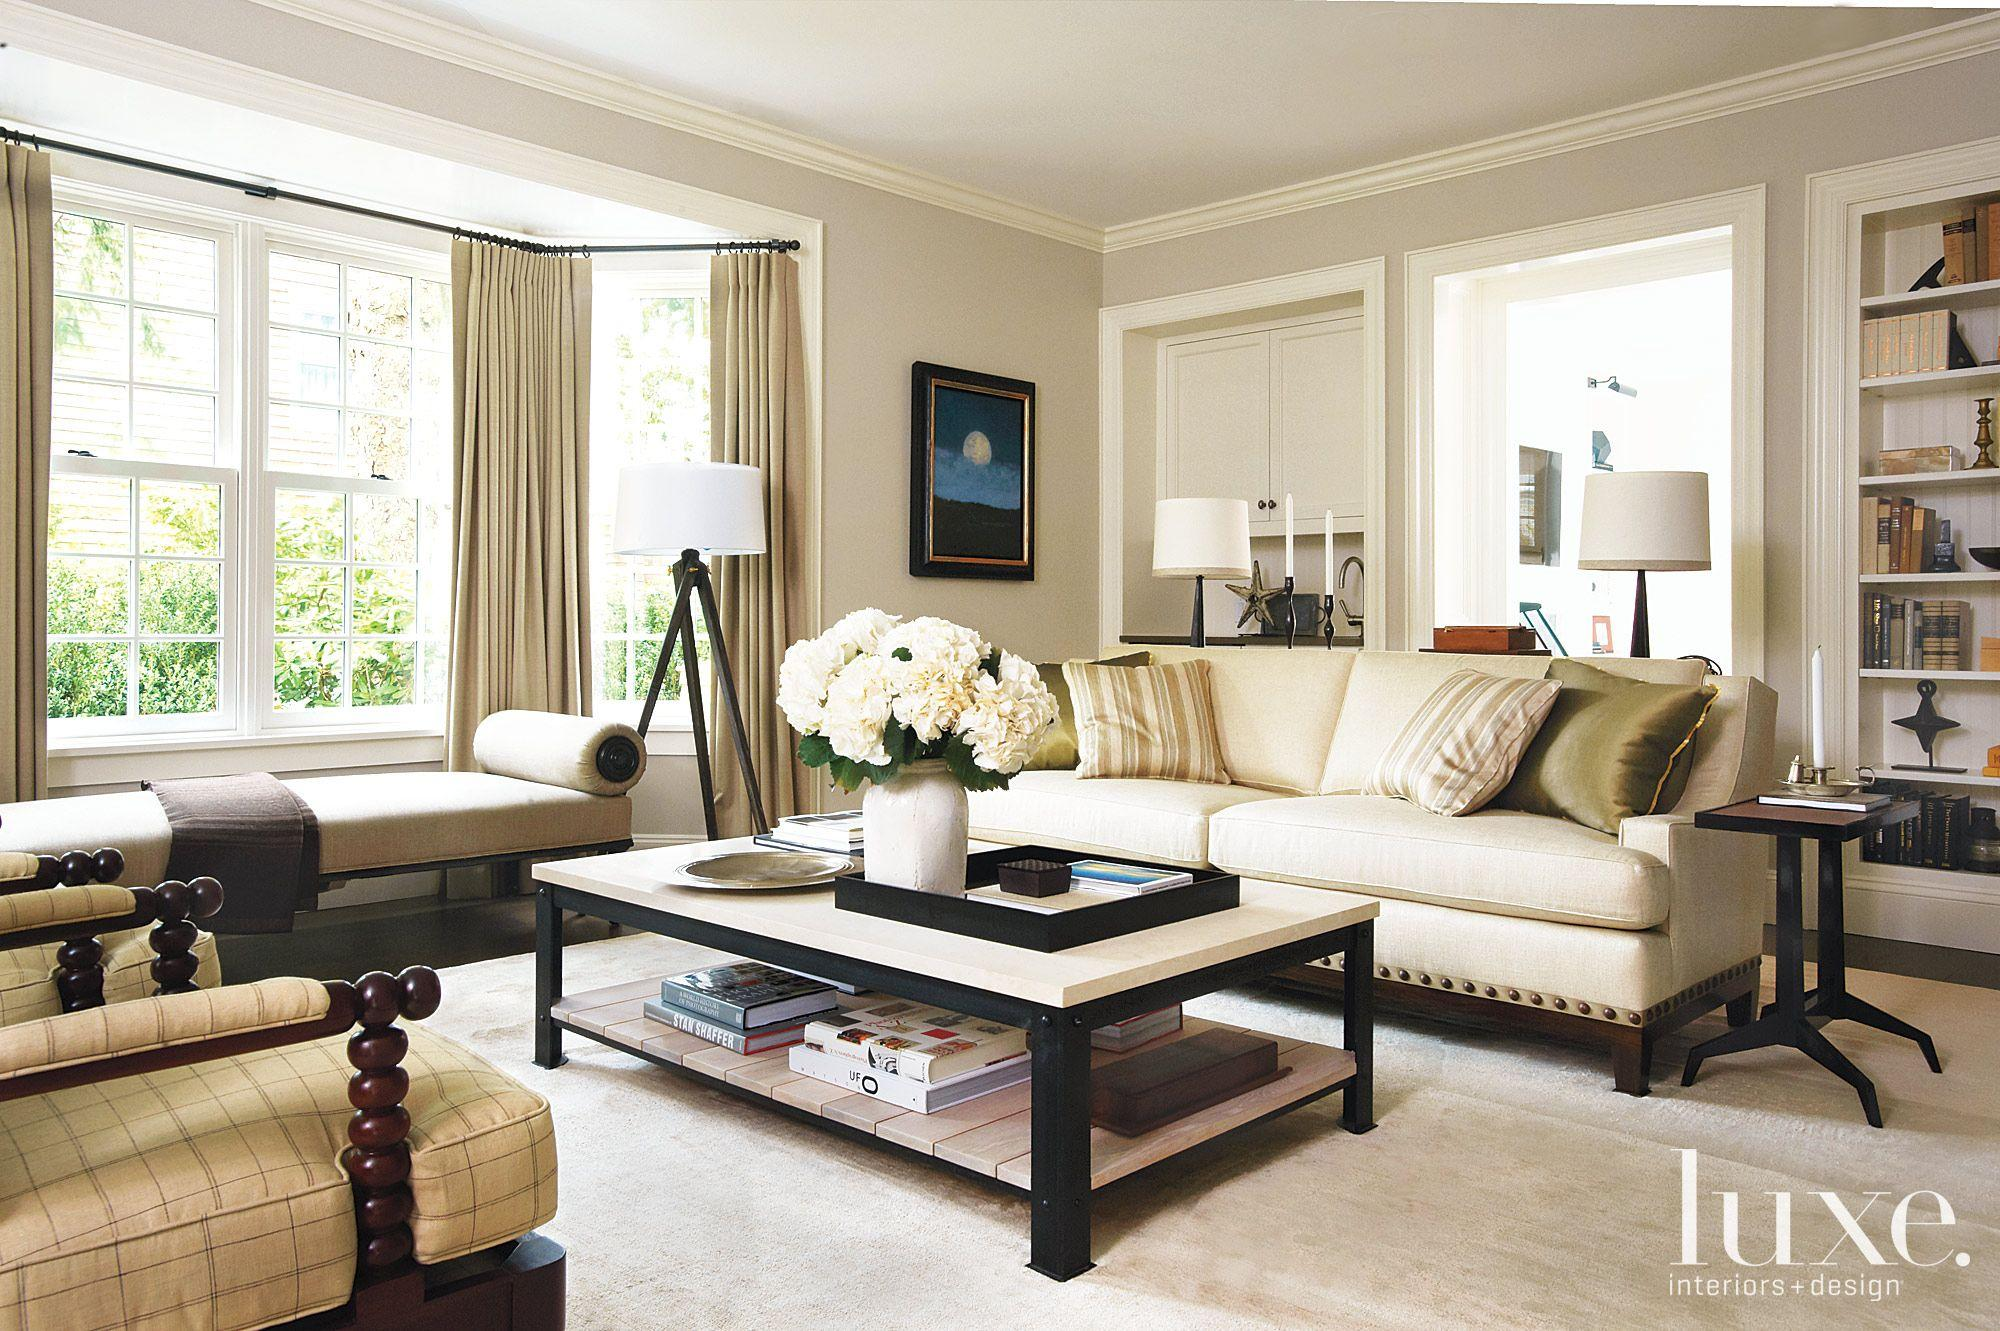

In [11]:
test_data[index]['image']

In [12]:
from transformers import MaskFormerImageProcessor

processor = MaskFormerImageProcessor(do_reduce_labels=True,ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

In [13]:
import numpy as np
from torch.utils.data import Dataset

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self,dataset,processor, transform=None):
        """
        Args:
            dataset
        """
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = np.array(self.dataset[idx]['image'].convert("RGB"))
        instance_seg = np.array(self.dataset[idx]['annotation'])[:,:,1]
        class_id_map = np.array(self.dataset[idx]['annotation'])[:,:,0]
        class_labels = np.unique(class_id_map)

        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})

        # apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            image, instance_seg = transformed['image'], transformed['mask']
            # convert to C, H, W
            image = image.transpose(2,0,1)

        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # Some image does not have annotation (all ignored)
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros((0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1]))
        else:
          inputs = self.processor([image], [instance_seg], instance_id_to_semantic_id=inst2class, return_tensors="pt")
          inputs = {k: v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()}

        return inputs


In [15]:
import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

# note that you can include more fancy data augmentation methods here
train_transform = A.Compose([
    A.Resize(width=512, height=512),
    #A.RandomResizedCrop(width=512, height=512, scale=(0.5, 1.0)),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.Rotate(limit=45),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

train_dataset = ImageSegmentationDataset(train_data, processor=processor, transform=train_transform)
test_dataset = ImageSegmentationDataset(test_data, processor=processor, transform=train_transform)

In [16]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = torch.stack([example["pixel_values"] for example in batch])
    pixel_mask = torch.stack([example["pixel_mask"] for example in batch])
    class_labels = [example["class_labels"] for example in batch]
    mask_labels = [example["mask_labels"] for example in batch]
    return {"pixel_values": pixel_values, "pixel_mask": pixel_mask, "class_labels": class_labels, "mask_labels": mask_labels}

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [20]:
from transformers import MaskFormerForInstanceSegmentation

# Replace the head of the pre-trained model
# We specify ignore_mismatched_sizes=True to replace the already fine-tuned classification head by a new one
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-large-ade",
                                                          #id2label=id2label,
                                                          ignore_mismatched_sizes=True)

params = list(model.parameters())

len(params)

model

# import torch
# import torch.nn as nn

# # Assuming 'model' is an instance of your MaskFormer model

# # Specify the number of layers to freeze in the encoder
# num_layers_to_freeze = 5

# # Get all the parameters of the model
# params = list(model.parameters())

# # Find the parameters associated with the encoder
# encoder_params = []
# for name, param in model.named_parameters():
#     if 'encoder' in name:
#         encoder_params.append(param)

# # Freeze the specified number of layers in the encoder
# for i in range(len(encoder_params)):
#     encoder_params[i].requires_grad = False

MaskFormerForInstanceSegmentation(
  (model): MaskFormerModel(
    (pixel_level_module): MaskFormerPixelLevelModule(
      (encoder): MaskFormerSwinBackbone(
        (model): MaskFormerSwinModel(
          (embeddings): MaskFormerSwinEmbeddings(
            (patch_embeddings): MaskFormerSwinPatchEmbeddings(
              (projection): Conv2d(3, 192, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): MaskFormerSwinEncoder(
            (layers): ModuleList(
              (0): MaskFormerSwinStage(
                (blocks): ModuleList(
                  (0-1): 2 x MaskFormerSwinLayer(
                    (layernorm_before): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
                    (attention): MaskFormerSwinAttention(
                      (self): MaskFormerSwinSelfAttention(
                        (query): Linear(in_

In [ ]:
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
# Set number of epochs and batch size
num_epochs = 100
for epoch in range(num_epochs):
    print(f"Epoch {epoch} | Training")
    # Set model in training mode
    model.train()
    train_loss, val_loss = [], []
    # Training loop
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Reset the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
            class_labels=[labels.to(device) for labels in batch["class_labels"]],
        )
        # Backward propagation
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        if idx % 50 == 0:
            print("  Training loss: ", round(sum(train_loss)/len(train_loss), 6))
        # Optimization
        optimizer.step()
    # Average train epoch loss
    train_loss = sum(train_loss)/len(train_loss)
    # Set model in evaluation mode
    model.eval()
    start_idx = 0
    print(f"Epoch {epoch} | Validation")
    for idx, batch in enumerate(tqdm(test_dataloader)):
        with torch.no_grad():
            # Forward pass
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )
            # Get validation loss
            loss = outputs.loss
            val_loss.append(loss.item())
            if idx % 50 == 0:
                print("  Validation loss: ", round(sum(val_loss)/len(val_loss), 6))
    # Average validation epoch loss
    val_loss = sum(val_loss)/len(val_loss)
    # Print epoch losses
    print(f"Epoch {epoch} | train_loss: {train_loss} | validation_loss: {val_loss}")

Epoch 0 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss:  2.277613


KeyboardInterrupt: 

In [ ]:
#---------------------------------------------------------Updated One-----------------------------------------------------------------------------------------------------------------#
import torch
from tqdm.auto import tqdm
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialize Adam optimizer with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)

# Set number of epochs and batch size
num_epochs = 100
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)  # Example learning rate scheduler

for epoch in range(num_epochs):
    print(f"Epoch {epoch} | Training")
    model.train()
    train_loss = []

    for idx, batch in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        outputs = model(
            pixel_values=batch["pixel_values"].to(device),
            mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
            class_labels=[labels.to(device) for labels in batch["class_labels"]],
        )
        loss = outputs.loss
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()

        if idx % 50 == 0:
            print("  Training loss:", round(sum(train_loss) / len(train_loss), 6))

    # Log or visualize training loss here

    scheduler.step()  # Update learning rate

    # Validation loop
    model.eval()
    val_loss = []

    for idx, batch in enumerate(tqdm(test_dataloader)):
        with torch.no_grad():
            outputs = model(
                pixel_values=batch["pixel_values"].to(device),
                mask_labels=[labels.to(device) for labels in batch["mask_labels"]],
                class_labels=[labels.to(device) for labels in batch["class_labels"]],
            )
            loss = outputs.loss
            val_loss.append(loss.item())

            if idx % 50 == 0:
                print("  Validation loss:", round(sum(val_loss) / len(val_loss), 6))

    # Log or visualize validation loss here

    print(f"Epoch {epoch} | train_loss: {train_loss[-1]} | validation_loss: {val_loss[-1]}")


Epoch 0 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 3.887635


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 2.612812
Epoch 0 | train_loss: 2.0592527389526367 | validation_loss: 2.61281156539917
Epoch 1 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 2.088648


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.75565
Epoch 1 | train_loss: 1.8946360349655151 | validation_loss: 1.7556500434875488
Epoch 2 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.825915


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.649971
Epoch 2 | train_loss: 1.8335511684417725 | validation_loss: 1.6499707698822021
Epoch 3 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.547369


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.697744
Epoch 3 | train_loss: 1.7617428302764893 | validation_loss: 1.6977437734603882
Epoch 4 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.576341


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.413011
Epoch 4 | train_loss: 1.5562098026275635 | validation_loss: 1.413010835647583
Epoch 5 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.557058


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.242812
Epoch 5 | train_loss: 1.6609933376312256 | validation_loss: 1.2428123950958252
Epoch 6 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.585356


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.269086
Epoch 6 | train_loss: 1.4649605751037598 | validation_loss: 1.2690857648849487
Epoch 7 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.438366


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.252482
Epoch 7 | train_loss: 1.3680400848388672 | validation_loss: 1.2524820566177368
Epoch 8 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.236902


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.127086
Epoch 8 | train_loss: 1.492180347442627 | validation_loss: 1.1270859241485596
Epoch 9 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.287699


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.193812
Epoch 9 | train_loss: 1.3012971878051758 | validation_loss: 1.1938120126724243
Epoch 10 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.057361


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.197159
Epoch 10 | train_loss: 1.1837191581726074 | validation_loss: 1.1971585750579834
Epoch 11 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.231223


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.054892
Epoch 11 | train_loss: 0.9637851715087891 | validation_loss: 1.054891586303711
Epoch 12 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.244936


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.13589
Epoch 12 | train_loss: 1.248936653137207 | validation_loss: 1.135890245437622
Epoch 13 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.052406


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 0.955156
Epoch 13 | train_loss: 1.092020869255066 | validation_loss: 0.9551563858985901
Epoch 14 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.16379


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.043057
Epoch 14 | train_loss: 0.9517991542816162 | validation_loss: 1.0430567264556885
Epoch 15 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.104883


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.048474
Epoch 15 | train_loss: 1.1082711219787598 | validation_loss: 1.0484743118286133
Epoch 16 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.10357


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 1.037699
Epoch 16 | train_loss: 0.8477332592010498 | validation_loss: 1.0376989841461182
Epoch 17 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.095638


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 0.97883
Epoch 17 | train_loss: 1.0080761909484863 | validation_loss: 0.9788301587104797
Epoch 18 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 0.965975


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 0.978184
Epoch 18 | train_loss: 1.115126132965088 | validation_loss: 0.9781842231750488
Epoch 19 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.05757


  0%|          | 0/1 [00:00<?, ?it/s]

  Validation loss: 0.947626
Epoch 19 | train_loss: 1.2691744565963745 | validation_loss: 0.9476261138916016
Epoch 20 | Training


  0%|          | 0/5 [00:00<?, ?it/s]

  Training loss: 1.180402


In [14]:
import gc
torch.cuda.empty_cache()
gc.collect()

3474

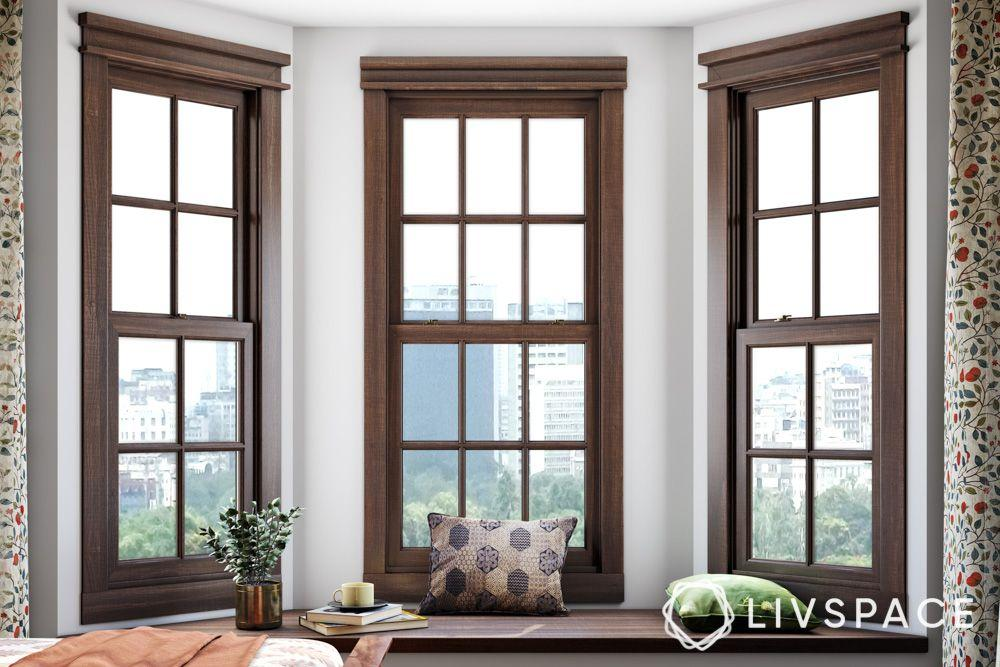

In [15]:
idx = 5

image = train_data[idx]["image"]
image

In [36]:
from transformers import MaskFormerImageProcessor

processor = MaskFormerImageProcessor()
processor.do_=True
#processor.do_resize=True

In [37]:
inputs = processor(image, return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 800, 1216])
pixel_mask torch.Size([1, 800, 1216])


In [38]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**inputs)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [19]:
results = processor.post_process_instance_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
print(results.keys())

dict_keys(['segmentation', 'segments_info'])


In [22]:
for segment in results['segments_info']:
  print(segment)

{'id': 0, 'label_id': 0, 'was_fused': False, 'score': 0.859678}
{'id': 1, 'label_id': 0, 'was_fused': False, 'score': 0.550764}


In [23]:
import numpy as np

def get_mask(segmentation, segment_id):
  mask = (segmentation.cpu().numpy() == segment_id)
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)

  return visual_mask

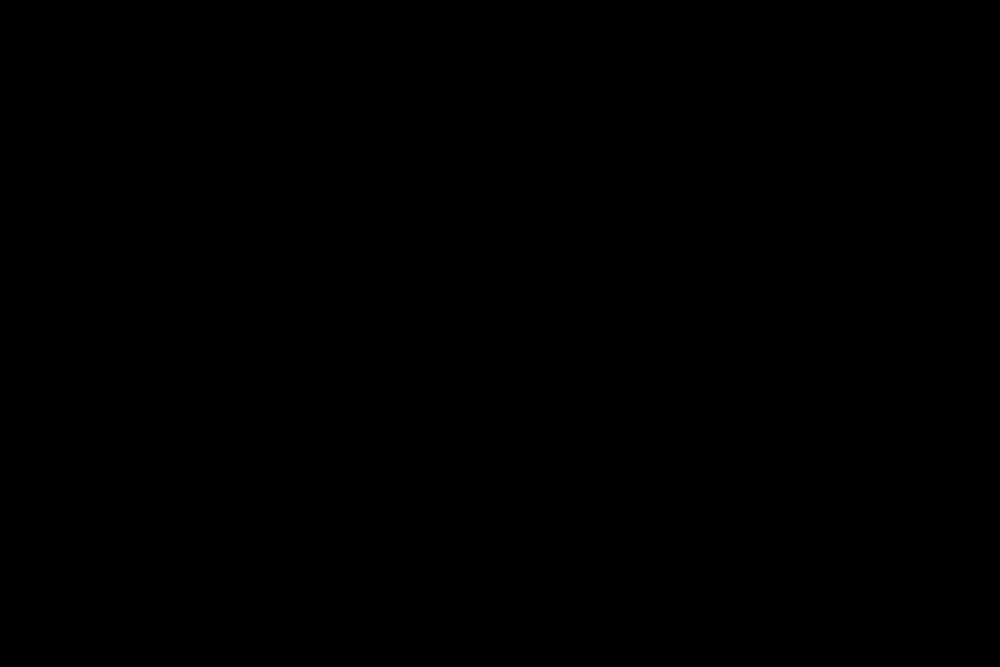

In [24]:
mask = (results['segmentation'].cpu().numpy() == 2)
visual_mask = (mask * 255).astype(np.uint8)
visual_mask = Image.fromarray(visual_mask)
visual_mask

In [25]:
np.unique(results['segmentation'].cpu().numpy())

array([-1.,  0.,  1.], dtype=float32)

Visualizing mask for instance: wall


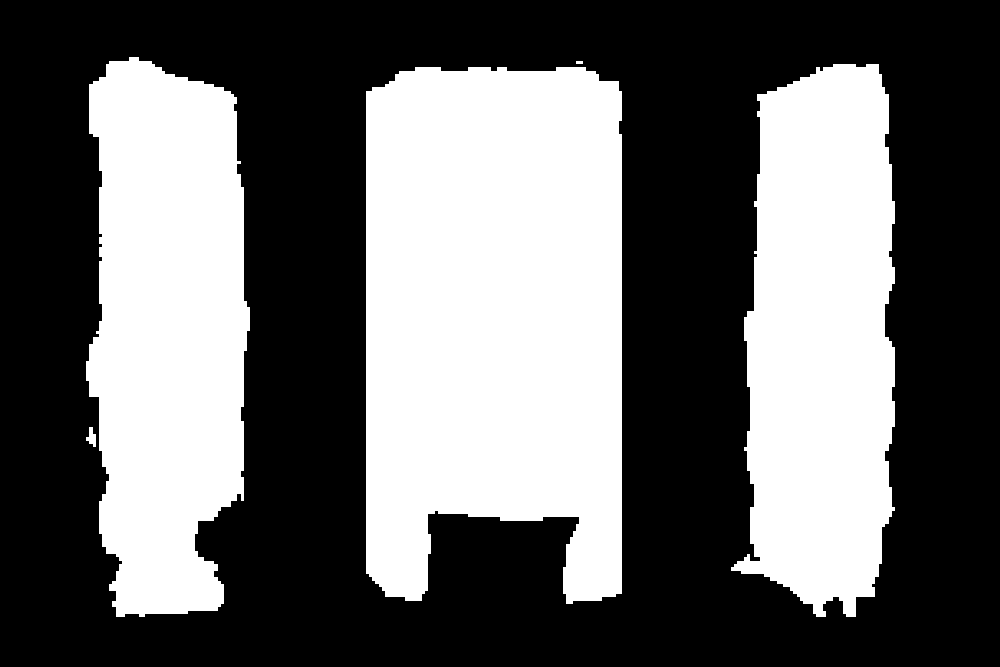

------
Visualizing mask for instance: wall


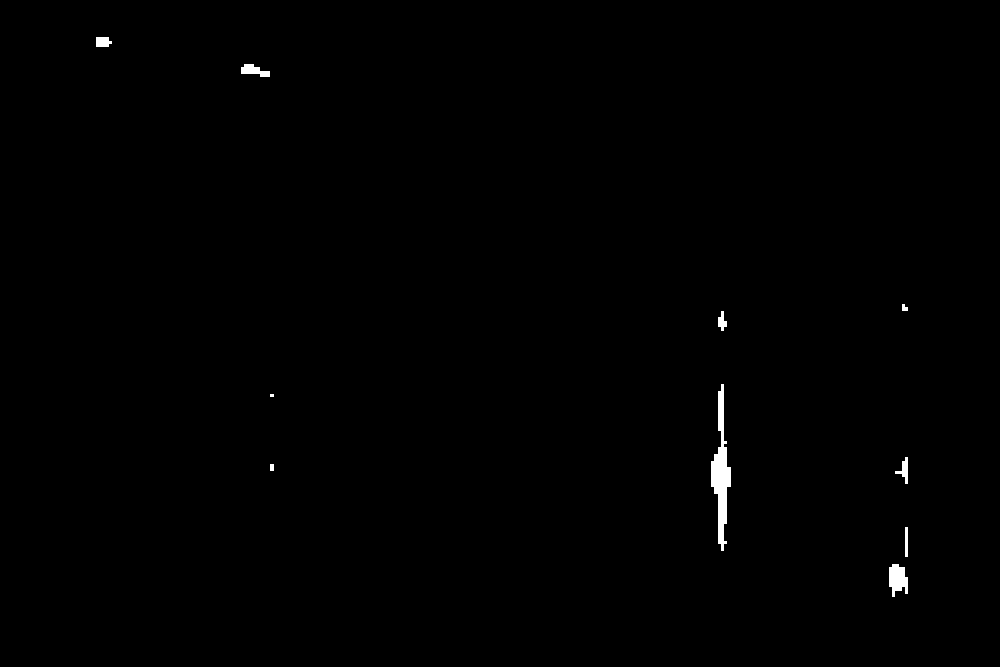

------


In [26]:
for segment in results['segments_info']:
    print("Visualizing mask for instance:", model.config.id2label[segment['label_id']])
    mask = get_mask(results['segmentation'], segment['id'])
    display(mask)
    print("------")